**APMA 940: Mathematics of Data Science**  
Project: *Association Rule Learning with Applications to Market Basket Analysis*  
Author: Javier Almonacid  
Date: April 12, 2023  

---  


# MBA Example 2: Online Retail Data Set

In this second example, we perform a market basket analysis on the "Online Retail" data set. This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. The implementation largely follows the ideas presented in [this tutorial](https://medium.com/@siglimumuni/market-basket-analysis-in-python-an-implementation-with-online-retail-data-d565c47ae7ae).

>Data Set Source: D. Chen, S. L. Sain & K. Guo. *Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining*. Journal of Database Marketing and Customer Strategy Management 19 (2012), no. 3, 197--208. Data set available at [http://archive.ics.uci.edu/ml/datasets/Online+Retail](http://archive.ics.uci.edu/ml/datasets/Online+Retail). Accessed on April 12, 2023.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules

pd.set_option('display.max_columns', 75)
pd.options.mode.chained_assignment = None

df = pd.read_excel("Online_Retail.xlsx")
print("Number of rows: "+str(len(df.index)))

# Compute number of transactions and items
print("Number of transactions: "+str(df['InvoiceNo'].nunique()))
print("Number of items: "+str(df['Description'].nunique()))
df

Number of rows: 541909
Number of transactions: 25900
Number of items: 4223


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## Preprocessing

In this database, we can see that multiple rows are associated to the same transaction ID (represented by `InvoiceNo`). Moreover, the database includes cancellations, which should not be included in the analysis. These are rows in which the invoice number starts with a "C".

In [2]:
# Removing cancellations from the data set
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print("After removing cancellations:")
print("  - Number of rows: "+str(len(df.index)))
print("  - Number of transactions: "+
      str(df['InvoiceNo'].nunique()))
print("  - Number of items: "+
      str(df['Description'].nunique()))

After removing cancellations:
  - Number of rows: 532621
  - Number of transactions: 22064
  - Number of items: 4207


Then, we check for missing values.

In [3]:
# Check for missing values in each column
print(df.isna().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64


Most of the missing values are coming from the `CustomerID` column and a smaller number from the `Description` column. Given that we still have more than 500,000 rows of data, we just simply remove the rows containing NaN or missing values.

In [4]:
df.dropna(inplace=True)

print("After removing rows with missing values:")
print("  - Number of rows: "+str(len(df.index)))
print("  - Number of transactions: "+
      str(df['InvoiceNo'].nunique()))
print("  - Number of items: "+
      str(df['Description'].nunique()))

After removing rows with missing values:
  - Number of rows: 397924
  - Number of transactions: 18536
  - Number of items: 3877


Without cancellations and missing values, we now merge the rows 

Continuing with the process of selecting an appropriate subset of data for our analysis, we have a look at the countries from which purchases are most common. As there is a one-to-one correspondence between invoice numbers and countries of origin, the count must be performed on unique `InvoiceNo` only.

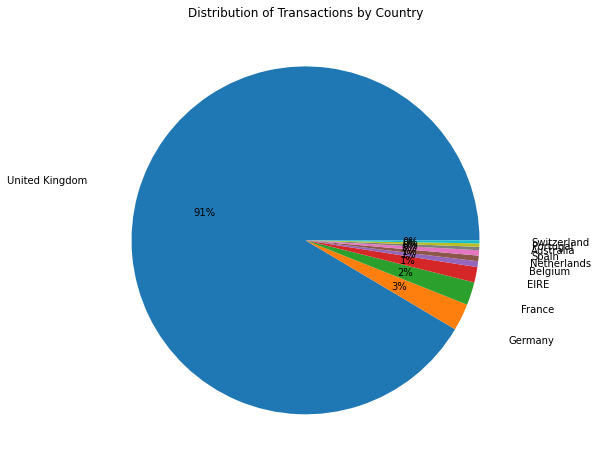

United Kingdom    16649
Germany             457
France              389
EIRE                260
Belgium              98
Netherlands          95
Spain                90
Australia            57
Portugal             57
Switzerland          51
Name: Country, dtype: int64

In [5]:
# Check the distribution of purchases per country
country_info = df.drop_duplicates(subset=['InvoiceNo', 'Country'], keep='first')
country_info = country_info["Country"].value_counts()

plt.figure(figsize=[8,8])
plt.pie(country_info.head(10), 
        labels=country_info.head(10).index, 
        autopct = '%0.0f%%',
        labeldistance=1.3)
plt.title("Distribution of Transactions by Country")
plt.show()

country_info.head(10)


Here, we observe that more than 16,000 transactions (91%) come from a single country (United Kingdom). Because the second place (Germany) only represents 457 transactions (which is a smaller number than in Example 1), we will just select transactions coming from the UK. This is the subset of data that we will analyze and that we can rearrange as a matrix `T` with entries `t_{ij}` equal to the quantity of item `j` purchased in transaction `i`.

In [6]:
# Basket construction for the analysis.
basket = df[df['Country'] =="United Kingdom"]\
        .groupby(['InvoiceNo', 'Description'])["Quantity"]\
        .sum().unstack()\
        .reset_index().fillna(0)\
        .set_index("InvoiceNo")
basket

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,...,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

We are almost done with the preprocessing part. Now, we convert the nonzero entries into ones (this process is sometimes called *one-hot encoding*), remove single-item transactions, and convert the numeric values into booleans.

In [7]:
# One-hot encoding
def to_binary(x):
    return 1 if (x >= 1) else 0

basket = basket.applymap(to_binary)
# Remove single-item transactions
basket = basket[(basket > 0).sum(axis=1) >= 2]

# Convert numeric values into booleans
basket = basket.applymap(bool)
basket

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PC CUTLERY SET PANTRY DESIGN,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,...,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW SHARK HELICOPTER,YELLOW/BLUE RETRO RADIO,YELLOW/ORANGE FLOWER DESIGN PLATE,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HEART FLOWER T-LIGHT HOLDER,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

## Association Rule Analysis

Now that the data is in the appropriate format, we can perform frequent itemset mining and association rule generation. We generate frequent itemsets with support of at least 3% using the FP-Growth algorithm. Then, we generate association rules with a confidence of at least 20%.

In [8]:
# Generate the frequent itemsets
frequent_itemsets = fpgrowth(basket, min_support=0.03, use_colnames=True)\
                    .sort_values("support",ascending=False)
print("Frequent itemsets found: "+str(len(frequent_itemsets.index))+"\n")
frequent_itemsets

Frequent itemsets found: 108



,support,itemsets
0,0.121358,(WHITE HANGING HEART T-LIGHT HOLDER)
33,0.093197,(JUMBO BAG RED RETROSPOT)
61,0.090466,(REGENCY CAKESTAND 3 TIER)
1,0.084417,(ASSORTED COLOUR BIRD ORNAMENT)
76,0.082986,(PARTY BUNTING)
...,...,...
67,0.030697,(DOORMAT UNION FLAG)
105,0.030632,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA..."
51,0.030502,(SET OF 3 HEART COOKIE CUTTERS)
58,0.030372,(DOLLY GIRL LUNCH BOX)


In [9]:
# Apply association rules
assoc_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)\
              .sort_values("conviction",ascending=False).reset_index(drop=True)
print("Rules found: "+str(len(assoc_rules.index)))
assoc_rules

Rules found: 8


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.039802,0.043900,0.030957,0.777778,17.717202,0.029210,4.302452,0.982670
1,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.043900,0.039802,0.030957,0.705185,17.717202,0.029210,3.256952,0.986881
2,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.052680,0.093197,0.032908,0.624691,6.702899,0.027999,2.416152,0.898124
3,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.055086,0.072841,0.030632,0.556080,7.634188,0.026620,2.088574,0.919671
4,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.064646,0.072841,0.031478,0.486922,6.684737,0.026769,1.807051,0.909181
5,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.072841,0.064646,0.031478,0.432143,6.684737,0.026769,1.647164,0.917216
6,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.072841,0.055086,0.030632,0.420536,7.634188,0.026620,1.630668,0.937283
7,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.093197,0.052680,0.032908,0.353105,6.702899,0.027999,1.464412,0.938253


Let us look at the output of the first two rules combined:
* 'GREEN REGENCY TEACUP AND SAUCER' and 'ROSES REGENCY TEACUP AND SAUCER' appeared together in 3.1% of the transactions. 
* 77.8% of the transactions in which 'GREEN REGENCY TEACUP AND SAUCER' was purchased, 'ROSES REGENCY TEACUP AND SAUCER' was also purchased. In turn, 70.5% percent in which 'ROSES REGENCY TEACUP AND SAUCER' was purchased, 'GREEN REGENCY TEACUP AND SAUCER' was also purchased.
  
This is an example in which, with high probability (about 70%), both items will be purchased at the same time. This makes sense as resellers would often like to offer several variations of the same product.  

Let us try to find association rules between more different items. For this, we will have to be more generous with the minimum support we are using to mine frequent itemsets.

In [11]:
# Reduce the min_support to 0.015 to obtain more frequent itemsets
fi2 = fpgrowth(basket, min_support=0.015, use_colnames=True)\
                    .sort_values("support",ascending=False)
print("Frequent itemsets found: "+str(len(fi2.index)))

ar2 = association_rules(fi2, metric="confidence", min_threshold=0.2)\
              .sort_values("conviction",ascending=False).reset_index(drop=True)
print("Rules found: "+str(len(ar2.index)))

# We will have a look at association rules that contain our most sold item: 
# 'WHITE HANGING HEART T-LIGHT HOLDER' as a consequent 
ar2 = ar2[ar2["consequents"].str.contains('WHITE HANGING HEART T-LIGHT HOLDER', regex=False)]
ar2


Frequent itemsets found: 518
Rules found: 280


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
9,(CANDLEHOLDER PINK HANGING HEART),(WHITE HANGING HEART T-LIGHT HOLDER),0.020552,0.121358,0.015284,0.743671,6.127912,0.012789,3.427789,0.854371
27,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.041623,0.121358,0.027836,0.668750,5.510557,0.022784,2.652504,0.854080
220,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.051314,0.121358,0.018600,0.362484,2.986901,0.012373,1.378228,0.701185
223,(WOODEN PICTURE FRAME WHITE FINISH),(WHITE HANGING HEART T-LIGHT HOLDER),0.055411,0.121358,0.019836,0.357981,2.949796,0.013112,1.368561,0.699768
251,(WOODEN FRAME ANTIQUE WHITE ),(WHITE HANGING HEART T-LIGHT HOLDER),0.050858,0.121358,0.016259,0.319693,2.634299,0.010087,1.291538,0.653635
277,(NATURAL SLATE HEART CHALKBOARD ),(WHITE HANGING HEART T-LIGHT HOLDER),0.060939,0.121358,0.016975,0.278549,2.295264,0.009579,1.217881,0.600941
278,(HEART OF WICKER SMALL),(WHITE HANGING HEART T-LIGHT HOLDER),0.060094,0.121358,0.016584,0.275974,2.274050,0.009291,1.213550,0.596076
279,(PARTY BUNTING),(WHITE HANGING HEART T-LIGHT HOLDER),0.082986,0.121358,0.017495,0.210815,1.737134,0.007424,1.113354,0.462740


The first rule in this table reads: 1.53% of transactions included both 'CANDLEHOLDER PINK HANGING HEART' and 'WHITE HANGING HEART T-LIGHT HOLDER'. Moreover, 74.4% of the transactions in which 'CANDLEHOLDER PINK HANGING HEART' was purchased, 'WHITE HANGING HEART T-LIGHT HOLDER' was also purchased. The high lift and conviction values indicate that this is a rule that should not be discarded. 

As a closing note, we must note that the experiments above are quite simplistic. As one might expect, the analysis of which rules should be kept and which ones should be discarded depends a lot on the person analyzing these results and the content of the database. Products are usually identified by SKU (stock keeping unit) numbers that can help to filter results according to manufacturer, brand, style, colour, size, and other attributes of an item.

In [ ]:
# print(frequent_itemsets.head(10).to_latex())
# print(ar2[["antecedents",
#                    "consequents",
#                    "antecedent support",
#                    "consequent support",
#                    "support",
#                    "confidence",
#                    "lift",
#                    "conviction"]].head(20).to_latex())